# Compute averages and autocorrelations on summary files

- data files are in this directory
- files are obtained using `pandas` HDF5 file writer
- each file has a name of the form `N24S16T045b` corresponding to parameters: $N=24$, $L=16$, $T=0.5$, and stream=`b`
- the columns are `traj, dH, cg_err, alpha_err, cg_it, energy, poly, R2, F2, acceptance`

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import emcee as em
import matplotlib.pyplot as plt
import os, sys
import lsqfit as ls
import gvar as gv
from glob import glob

Define functions to select the file base on the parameters. 

Include the possibility of different streams

In [3]:
import re
def get_params(filename):
    if '/' in filename:
        filename = filename.split('/')[-1]
    params = filename.split('_')[0]
    if re.search('[a-d]$',params):
        par = params[:-1]
        stream = params[-1]
    else:
        par = params
        stream = 'a'
        
    n = int(par.split('N')[1].split('S')[0])
    s = int(par.split('S')[1].split('T')[0])
    t = str(par.split('T')[1])
    t = '{0}.{1}'.format(t[0],t[1:])
    t = float(t)
    r = stream
    return n,s,t,r

### Test analysis procedure on one single file

Define the parameters of the ensemble by getting them from the name of the file:

In [30]:
prefix='data_from_oslic/'
filename=prefix+'N24S16T04_improved.h5'

In [31]:
get_params(filename)

(24, 16, 0.4, 'a')

Get the data from the file into a `pandas` dataframe. Since it was created with `pandas` `write_hdf` function, we can simply use `read_hdf` and the dataframe will be read correctly, with the correct column header.

In [32]:
df = pd.read_hdf(filename)
df.head()

,traj,dH,cg_err,alpha_err,cg_it,E,Pol,trx,trxy,leig,seig,acc
0,1,-1.030079084,0,0,533,65.762291,0.868524,0.692894,0.863307,16.7823411,0.007968,1.0
1,2,-0.459381479,0,0,587,48.840538,0.861272,1.447799,3.657932,17.6511327,0.007014,1.0
2,3,316.434547655,0,0,676,35.287288,0.834769,2.054913,6.977477,18.2269058,0.005584,1.0
3,4,8.636693847,0,0,715,25.420079,0.825137,2.462883,9.629015,18.5218233,0.005087,1.0
4,5,-0.703243570,0,0,756,17.975954,0.831075,2.736588,11.618125,18.7345847,0.004656,1.0


Look at thermalization: first 1000 trajectories for the energy

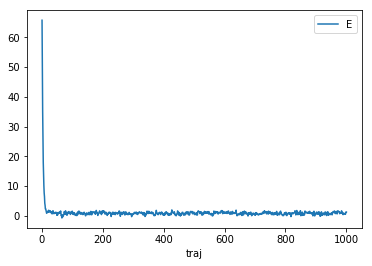

In [7]:
df.iloc[:1000].plot('traj','E')

In [13]:
df.shape

(18254, 12)

Cut the first 1000 trajectories and look at a different observable: $Tr[X^2]$

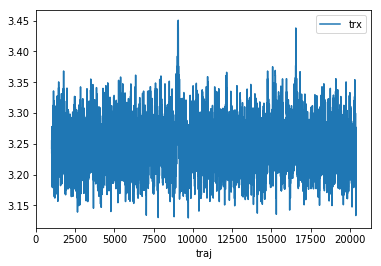

In [9]:
df.iloc[1000:].plot('traj','trx')

or $Tr[X,Y]^2$

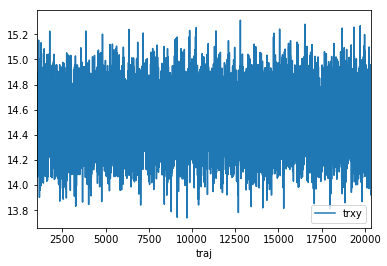

In [20]:
df.iloc[1000:].plot('traj','trxy')

Can also look at the acceptance

In [17]:
df['dH'].tail()

18249    -0.013463242
18250    -0.033777181
18251     0.035361378
18252     0.004545841
18253     0.015296068
Name: dH, dtype: object

In [11]:
print('Average acceptance: {:.1f}%'.format(df.acc.mean()*100))

Average acceptance: 98.5%


or look at CG iterations

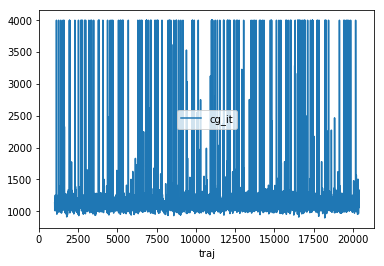

In [10]:
df.iloc[1000:].plot('traj','cg_it')

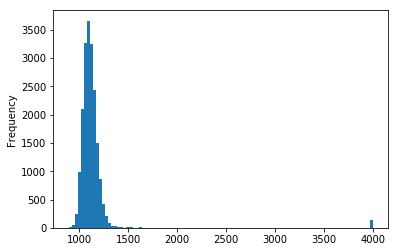

In [8]:
df['cg_it'].iloc[1000:].plot.hist(bins=100)

## Define function to plot the observables

In [9]:
def plt_obs(filename,obs,cut=1000,bins=100,prefix='figures_obs',figshow=False):
    ##### Get parameters ...
    N, L, T, s = get_params(filename)
    ##### Reading ...
    df = pd.read_hdf(filename)
    if (df.shape[0]<cut): return print('{:s} is shorter than cut={:d}'.format(filename,cut))
    ##### Plotting ...
    fig, (ax0,ax1) = plt.subplots(2,figsize=(12,6))
    df[obs].iloc[cut:].plot(ax=ax0)
    df[obs].iloc[cut:].plot.hist(bins=100,ax=ax1)
    ax0.set_title('N={:d} L={:d} T={:.3f} s={:s} OBS={:s} cut={:d}'.format(N, L, T, s, obs, cut))
    plt.savefig(prefix+'/N{:d}_L{:d}_T{:s}_s{:s}_{:s}_c{:d}.png'.format(N, L,str(T).replace('.',''), s, obs, cut),dpi=150)
    if figshow: plt.show()
    plt.close() # avoid memory problems

In [40]:
def plt_obs_nice(filename,obs,cut=1000,bins=100,prefix='figures_obs',figshow=False):
    ##### Get parameters ...
    N, L, T, s = get_params(filename)
    ##### Reading ...
    df = pd.read_hdf(filename)
    if (df.shape[0]<cut): return print('{:s} is shorter than cut={:d}'.format(filename,cut))
    ##### Plotting ...
    fig, ax = plt.subplots(1,2,figsize=(9,6),sharey=True,gridspec_kw={'width_ratios':[4,1]})
    # Remove horizontal space between axes
    fig.subplots_adjust(wspace=0)
    df[obs].iloc[cut:].plot(ax=ax[0])
    df[obs].iloc[cut:].plot.hist(bins=100,ax=ax[1],orientation='horizontal')
    ax[0].set_xlabel('traj.')
    ax[1].set_xlabel('count')    
    ax[0].set_title('N={:d} L={:d} T={:.3f} s={:s} OBS={:s} cut={:d}'.format(N, L, T, s, obs, cut))
    plt.savefig(prefix+'/nice_N{:d}_L{:d}_T{:s}_s{:s}_{:s}_c{:d}.png'.format(N, L,str(T).replace('.',''), s, obs, cut),dpi=150)
    if figshow: plt.show()
    plt.close() # avoid memory problems

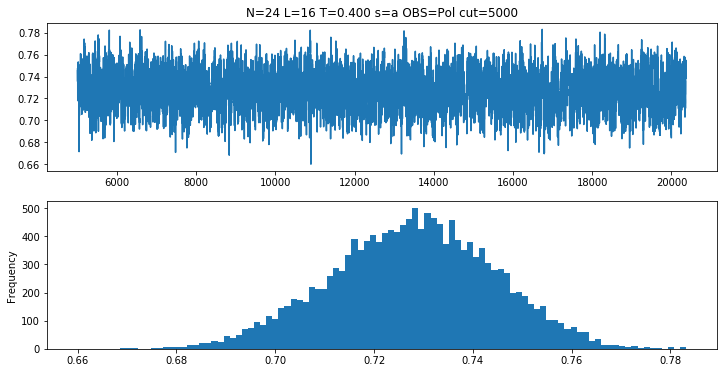

In [37]:
plt_obs(filename,'Pol',cut=5000,figshow=True)

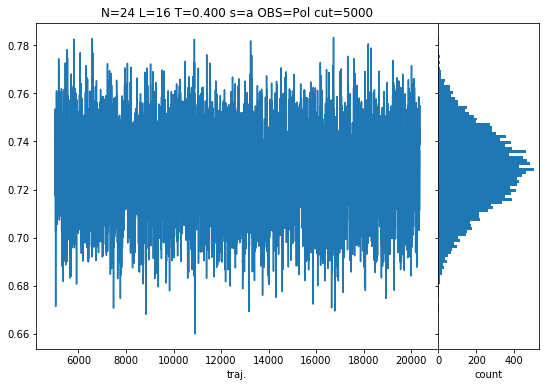

In [39]:
plt_obs_nice(filename,'Pol',cut=5000,figshow=True)

In [11]:
tau=em.autocorr.integrated_time(df['Pol'].iloc[1000:].values, c=10)

In [12]:
print(tau)

10.611744429549224


## Run the analysis procedure on all the files

Do a loop over all the files and analyze the energy, writing out the corresponding averages.

It is worth defining a function that does the full analysis on a specific file

In [23]:
def do_analysis(filename,obs,cut=1000):
    ##### Get parameters ...
    N, L, T, s = get_params(filename)
    
    ##### Reading ...
    df = pd.read_hdf(filename)

    ##### Calculating ...
    obs_data=df[obs].values
    obs_data=obs_data[cut:] ## thermalization cut
    try:
        tau=em.autocorr.integrated_time(obs_data, c=10) # c=5 is used to constrain the window used for tau    
    except AutocorrError:
        print('Skip data because I don\'t know the autocorrelation time')
        return 

    bw=int(tau*5)
    bins=gv.dataset.bin_data(obs_data,binsize=bw)
    gv_avg=gv.dataset.avg_data(bins)

    ##### Printing ...
    print('{:d} {:d} {:.3f} {} {} | {:d} {:d} {:s}'
          .format(N,L,T,gv.mean(gv_avg),gv.sdev(gv_avg),len(obs_data),len(bins),s))

    return N, L, T, s, gv_avg, len(obs_data), len(bins)

Define a new analysis function that would work only for temperatures $T\le1.0$ and that will cut the data to keep only the stable part of `trx`, with `trx`$<4.0$. The latter cut is empirically observed to be the largest value (which happens for larger L, larger T and lower N, e.g. for us it's L=64, N=16 and T=1.0)

In [13]:
def do_analysis_cutoff(filename,obs,cut=1000,R2cutoff=4.0,Tcutoff=1.0):
    ##### Get parameters ...
    N, L, T, s = get_params(filename)
    if (T>Tcutoff):
        print('# Tcutoff reached: {:.3f}>{:.3f} . Skipping ensemble N={:d} L={:d} T={:.3f} s={:d}'.format(T,Tcutoff,N,L,T,s))
        return
    ##### Reading ...
    df = pd.read_hdf(filename)
    
    ###### Select data within R2cutoff ...
    df = df.loc[df.trx<R2cutoff]
    if (df.size<cut):
        print('# low stats: data<cut ({:d}<{:d}) . Skipping ensemble N={:d} L={:d} T={:.3f} s={:s}'.format(df.size,cut,N,L,T,s))
        return
    ##### Thermalization cut ...
    obs_data=df[obs].values
    obs_data=obs_data[cut:]
    ##### Calculate autocorr time and binned average
    try:
        tau=em.autocorr.integrated_time(obs_data, c=10) # c=10 is used as a more rigid constraint for the window used for tau    

        bw=int(tau*5)
        bins=gv.dataset.bin_data(obs_data,binsize=bw)
        gv_avg=gv.dataset.avg_data(bins)

    ##### Printing ...
        print('{:d} {:d} {:.3f} {} {} | {:d} {:d} {:s}'.format(N,L,T,gv.mean(gv_avg),gv.sdev(gv_avg),len(obs_data),len(bins),s))
    except:
        print('# AutocorrError: Skipping ensemble N={:d} L={:d} T={:.3f} s={:s}'.format(N,L,T,s))
        pass

Get average values for CG iterations. Since there are spikes, we need to cut the distribution and then ignore the autocorrelation time because it is not a physical observable.

In [23]:
def do_analysis_cg(filename,obs,cut=1000,CGcutoff=2000,Tcutoff=1.0):
    ##### Get parameters ...
    N, L, T, s = get_params(filename)
    if (T>Tcutoff):
        print('# Tcutoff reached: {:.3f}>{:.3f} . Skipping ensemble N={:d} L={:d} T={:.3f} s={:d}'.format(T,Tcutoff,N,L,T,s))
        return
    ##### Reading ...
    df = pd.read_hdf(filename)
    
    ###### Select data within CGcutoff ...
    df = df.loc[df.cg_it<CGcutoff]
    if (df.size<cut):
        print('# low stats: data<cut ({:d}<{:d}) . Skipping ensemble N={:d} L={:d} T={:.3f} s={:s}'.format(df.size,cut,N,L,T,s))
        return
    ##### Thermalization cut ...
    obs_data=df[obs].values
    obs_data=obs_data[cut:]
    ##### Calculate average
    try:
        bins=gv.dataset.bin_data(obs_data,binsize=100)
        gv_avg=gv.dataset.avg_data(bins)
    ##### Printing ...
        print('{:d} {:d} {:.3f} {} {} | {:d} {:d} {:s}'.format(N,L,T,gv.mean(gv_avg),gv.sdev(gv_avg),len(obs_data),len(bins),s))
    except:
        print('# Skipping ensemble N={:d} L={:d} T={:.3f} s={:s}'.format(N,L,T,s))
        pass

First select all the files with `improved` results in the folder.

In [41]:
files = glob('data_from_oslic/N*_improved.h5')

In [42]:
files.sort()

In [43]:
len(files)

223

In [17]:
do_analysis_cutoff(filename,'Pol',cut=5000)

24 16 0.400 0.7277817858119991 0.00038782457275243017 | 15374 301 a


### Plot observable for all files

In [45]:
for filename in files:
    plt_obs_nice(filename,'trx',cut=1000,prefix='figures_obs')

data_from_oslic/N128S8T04_improved.h5 is shorter than cut=1000
data_from_oslic/N128S8T04b_improved.h5 is shorter than cut=1000
data_from_oslic/N12S12T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S16T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S24T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S8T01_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T0425b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T045b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T0475b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T01_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T02_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0375c_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0375d_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0425b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T045b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0475b_improve

In [46]:
for filename in files:
    plt_obs_nice(filename,'E',cut=1000,prefix='figures_obs')

data_from_oslic/N128S8T04_improved.h5 is shorter than cut=1000
data_from_oslic/N128S8T04b_improved.h5 is shorter than cut=1000
data_from_oslic/N12S12T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S16T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S24T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S8T01_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T0425b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T045b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T0475b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T01_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T02_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0375c_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0375d_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0425b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T045b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0475b_improve

In [47]:
for filename in files:
    plt_obs_nice(filename,'Pol',cut=1000,prefix='figures_obs')

data_from_oslic/N128S8T04_improved.h5 is shorter than cut=1000
data_from_oslic/N128S8T04b_improved.h5 is shorter than cut=1000
data_from_oslic/N12S12T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S16T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S24T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S8T01_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T0425b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T045b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T0475b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T01_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T02_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0375c_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0375d_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0425b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T045b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0475b_improve

In [16]:
for filename in files:
    plt_obs(filename,'cg_it',cut=1000,prefix='figures_obs')

data_from_oslic/N128S8T04_improved.h5 is shorter than cut=1000
data_from_oslic/N128S8T04b_improved.h5 is shorter than cut=1000
data_from_oslic/N12S12T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S16T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S24T01_improved.h5 is shorter than cut=1000
data_from_oslic/N12S8T01_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T0425b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T045b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S12T0475b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T01_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T02_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0375c_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0375d_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0425b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T045b_improved.h5 is shorter than cut=1000
data_from_oslic/N32S16T0475b_improve

### Run analysis for all files

In [19]:
for filename in files:
#     do_analysis(filename,'E')
#    do_analysis_cutoff(filename,'Pol',cut=5000)
    do_analysis_cutoff(filename,'trx',cut=5000)

# AutocorrError: Skipping ensemble N=128 L=8 T=0.400 s=a
# low stats: data<cut (4236<5000) . Skipping ensemble N=128 L=8 T=0.400 s=b
# low stats: data<cut (420<5000) . Skipping ensemble N=12 L=12 T=0.100 s=a
12 12 0.650 3.308615917294587 0.0022474394048769965 | 20600 192 a
12 12 0.750 3.348452194964965 0.0014628159822959973 | 20000 555 a
12 12 0.850 3.3887743420104126 0.0015686246561588033 | 20000 454 a
# low stats: data<cut (528<5000) . Skipping ensemble N=12 L=16 T=0.100 s=a
12 16 0.650 3.388409522610448 0.0026556082561489903 | 20400 153 a
12 16 0.750 3.4229475511852554 0.002551176522393193 | 19200 171 a
12 16 0.850 3.460171440204934 0.0026428627974872886 | 20600 176 a
# low stats: data<cut (4428<5000) . Skipping ensemble N=12 L=24 T=0.100 s=a
12 24 0.650 3.47415550928073 0.004009255641853198 | 18660 46 a
12 24 0.750 3.495358246185185 0.0031571993061387804 | 19050 63 a
12 24 0.850 3.5233016971663713 0.0030575729744244523 | 20310 114 a
12 32 0.650 3.534790695323654 0.00431431532319670

24 32 0.425 3.419805637037037 0.0016866718305555968 | 15054 54 a
24 32 0.425 3.419853867496946 0.0017530512675712543 | 14922 53 b
# AutocorrError: Skipping ensemble N=24 L=32 T=0.450 s=a
# AutocorrError: Skipping ensemble N=24 L=32 T=0.450 s=b
# AutocorrError: Skipping ensemble N=24 L=32 T=0.475 s=a
24 32 0.475 3.4370871250778086 0.001705500408121238 | 12926 51 b
24 32 0.400 3.410640089233177 0.001292477490766505 | 15984 71 a
24 32 0.500 3.4460786632412526 0.001075784531538797 | 16372 181 a
24 32 0.650 3.4920211969880306 0.0010307345680239909 | 15410 244 a
24 32 0.600 3.4780272388914026 0.001085487634477203 | 17742 208 a
24 32 0.750 3.520883488318754 0.0010332735538497347 | 18750 218 a
24 32 0.700 3.5075176034195645 0.001150468303013701 | 19164 217 a
24 32 0.850 3.5524753445535713 0.0012853074842199572 | 16840 200 a
24 32 0.800 3.537125338518897 0.0012335230711879718 | 19586 178 a
24 32 0.900 3.566156859457167 0.0015984227270093951 | 17780 131 a
24 32 1.000 3.599992994444444 0.00163913

In [24]:
for filename in files:
    do_analysis_cg(filename,'cg_it',cut=1000)

# Skipping ensemble N=128 L=8 T=0.400 s=a
# Skipping ensemble N=128 L=8 T=0.400 s=b
# Skipping ensemble N=12 L=12 T=0.100 s=a
12 12 0.650 378.9144081632653 0.4629871616540294 | 24591 245 a
12 12 0.750 332.58313807531385 0.37329908355295083 | 23968 239 a
12 12 0.850 299.730460251046 0.36126486518874945 | 23946 239 a
# low stats: data<cut (804<1000) . Skipping ensemble N=12 L=16 T=0.100 s=a
12 16 0.650 502.33197530864203 0.6841023964823043 | 24393 243 a
12 16 0.750 436.9891341991342 0.5331121186746275 | 23194 231 a
12 16 0.850 393.35510204081635 0.41349542643091397 | 24587 245 a
# low stats: data<cut (24<1000) . Skipping ensemble N=12 L=24 T=0.100 s=a
12 24 0.650 744.9963274336283 1.2220463187538868 | 22651 226 a
12 24 0.750 649.863347826087 0.8795886553881864 | 23036 230 a
12 24 0.850 585.2659917355372 0.6552228840097575 | 24294 242 a
12 32 0.650 979.1254634146343 1.6122336254652796 | 20598 205 a
12 32 0.750 855.4503781512606 1.1484930260783521 | 23844 238 a
12 32 0.850 771.144347826087

24 32 0.650 1022.5955497382199 0.85227456801847 | 19197 191 a
24 32 0.600 1116.2305555555556 1.0639088490267823 | 21663 216 a
24 32 0.750 889.968206278027 0.6993097932557912 | 22367 223 a
24 32 0.700 945.0090869565219 0.7664998505871422 | 23058 230 a
24 32 0.850 806.0151231527094 0.7634906680770583 | 20339 203 a
24 32 0.800 838.935407725322 0.6096512151868966 | 23385 233 a
24 32 0.900 766.6919534883722 0.6193623647557401 | 21573 215 a
24 32 1.000 713.14 0.7893849807218654 | 19100 191 a
24 8 0.400 452.39692307692314 5.8951521939706835 | 1325 13 a
24 8 0.500 362.03125 0.39301152558282487 | 20899 208 a
24 8 0.650 269.4943925233645 0.5381348434825834 | 21472 214 a
24 8 0.600 289.94894957983195 0.3314698515794309 | 23893 238 a
24 8 0.750 237.98191235059764 0.5450528705888471 | 25155 251 a
24 8 0.700 248.48063414634146 0.38024239795572057 | 20576 205 a
24 8 0.850 218.81132075471697 0.731685407050885 | 26578 265 a
24 8 0.800 223.073698630137 0.6477291884452718 | 21965 219 a
24 8 0.900 205.917

## Plot Polyakov loop values

In [48]:
filename='datasets/Pol_5000-all.dat'

In [51]:
column_names=['N', 'L', 't', 'Pol', 'error', 'cfgs', 'bins', 'stream']
df = pd.read_table(filename,delimiter='\s+',usecols=[0,1,2,3,4,6,7,8],header=None,skip_blank_lines=True,comment='#',names=column_names)
df.head()

,N,L,t,Pol,error,cfgs,bins,stream
0,12,12,0.65,0.856316,0.000390,20600,396,a
1,12,12,0.75,0.882045,0.000208,20000,740,a
2,12,12,0.85,0.900443,0.000165,20000,952,a
3,12,16,0.65,0.857448,0.000447,20400,318,a
4,12,16,0.75,0.883084,0.000335,19200,349,a


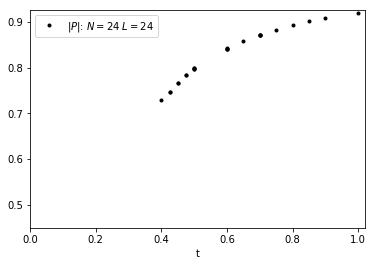

In [27]:
df.loc[(df.N==24) & (df.L==24)].plot('t','Pol',style='k.',legend=True,label=r'$|P|$: $N=24$ $L=24$',xlim=[0,1.02],ylim=[0.45,0.925])

In [58]:
np.unique(df.N.values)

array([12, 16, 24, 32])

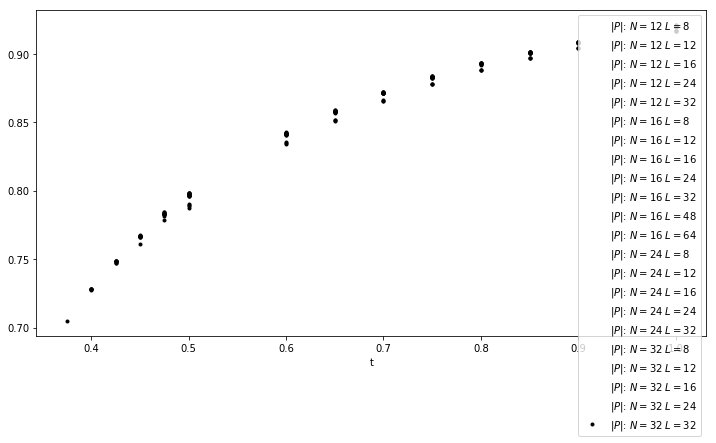

In [63]:
fig, ax = plt.subplots(figsize=(12,6))
for n in np.unique(df.N.values):
    for l in np.unique(df.loc[df.N==n].L.values):
        df.loc[(df.N==n) & (df.L==l)].plot('t','Pol',style='k.',legend=True,label=r'$|P|$: $N=${} $L=${}'.format(n,l),ax=ax)

## Plot CG iterations

In [25]:
filename='datasets/cg_it.dat'

In [26]:
column_names=['N', 'L', 't', 'CG', 'error', 'cfgs', 'bins', 'stream']
df = pd.read_table(filename,delimiter='\s+',usecols=[0,1,2,3,4,6,7,8],header=None,skip_blank_lines=True,comment='#',names=column_names)
df.head()

,N,L,t,CG,error,cfgs,bins,stream
0,12,12,0.65,378.914408,0.462987,24591,245,a
1,12,12,0.75,332.583138,0.373299,23968,239,a
2,12,12,0.85,299.730460,0.361265,23946,239,a
3,12,16,0.65,502.331975,0.684102,24393,243,a
4,12,16,0.75,436.989134,0.533112,23194,231,a


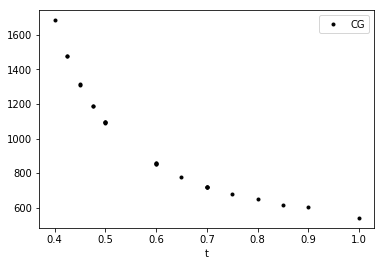

In [45]:
df.loc[(df.N==24) & (df.L==24)].plot('t','CG',style='k.')

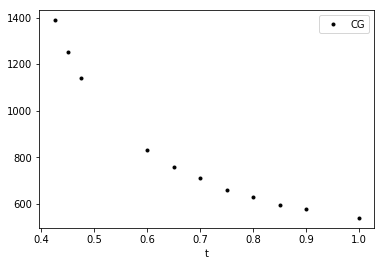

In [47]:
df.loc[(df.N==16) & (df.L==24)].plot('t','CG',style='k.')

## Compare different streams

Load complete database

In [ ]:
##### Reading ...
column_names=['N', 'L', 't', 'energy', 'error', 'cfgs', 'bins', 'stream']
df = pd.read_table('from_masanori/ungauged_energy_allstreams_cut1000.txt',delimiter='\s+',usecols=[0,1,2,3,4,6,7,8],header=None,skip_blank_lines=True,comment='#',names=column_names)
df.head()

Look at different values of $N$, $L$ and $T$.

In [ ]:
for Nc in [16,24,32]:
    df.loc[df.N==Nc].plot(x='L',y='t',sort_columns=True,kind='scatter',title='Parameters for $N=${}'.format(Nc),ylim=[0,2],xticks=[8,16,24,32,64])


Use `groupby` to collect streams into groups with the same parameters

In [ ]:
df0=df.groupby(['N','L','t'])

In [ ]:
n16s64t05_streams=df0.get_group((16,64,0.5))

In [ ]:
n16s64t05_streams

Compare energy and error on the different stream

In [ ]:
plt.title('$N=$16 $L=$64 $T=$0.5 streams')
plt.xticks(n16s64t05_streams['stream'].values)
plt.ylabel('E')
plt.xlabel('stream')
plt.errorbar(x=n16s64t05_streams['stream'].values,y=n16s64t05_streams['energy'].values,yerr=n16s64t05_streams['error'].values,fmt='o')

Compare number of bins on different streams

In [ ]:
plt.title('$N=$16 $L=$64 $T=$0.5 streams')
plt.xticks(n16s64t05_streams['stream'].values)
plt.ylabel('bins')
plt.xlabel('stream')
plt.scatter(n16s64t05_streams['stream'].values,n16s64t05_streams['bins'].values)

In [ ]:
n16s64t09_streams['bins'].sum()

Compare autocorrelation time on different streams: $\tau = N_{cfgs}/(3*N_{bins})$

In [ ]:
plt.title('$N=$16 $L=$64 $T=$0.9 streams')
plt.xticks(n16s64t09_streams['stream'].values)
plt.ylabel(r'$\tau$')
plt.xlabel('stream')
plt.scatter(n16s64t09_streams['stream'].values,n16s64t09_streams['cfgs'].values/(3.*n16s64t09_streams['bins'].values))

Try averaging different streams using `lsqfit.wavg`

In [ ]:
gvals = gv.gvar(n16s64t09_streams['energy'].values,n16s64t09_streams['error'].values)

In [ ]:
gavg = ls.wavg(list(gvals))

In [ ]:
gavg.mean

In [ ]:
plt.xticks(n16s64t09_streams['stream'].values)
plt.ylabel('E')
plt.xlabel('stream')
plt.errorbar(x=n16s64t09_streams['stream'].values,y=n16s64t09_streams['energy'].values,yerr=n16s64t09_streams['error'].values,fmt='o')
plt.axhline(gavg.mean,color='k',ls='--')
plt.axhspan(gavg.mean+gavg.sdev,gavg.mean-gavg.sdev,color='k',alpha=0.2)